## Task 1: Sentence Transformer Implementation

We implement a sentence transformer using the `all-mpnet-base-v2` checkpoint from Hugging Face. This model is chosen for its strong generalization, moderate size, and high-quality sentence embeddings, which are well-suited for both general and task-specific applications. The architecture consists of a shared transformer encoder that produces contextualized token embeddings, followed by mean pooling (using the attention mask) to generate a fixed-length sentence embedding. This design leverages all token representations and is robust to input length variation. We test the model by encoding a few sample sentences and inspecting their embeddings.

**Key design choices:**
- **Model selection:** `all-mpnet-base-v2` balances size and performance, and is optimized for sentence-level tasks.
- **Pooling:** Mean pooling over tokens ensures that the sentence embedding represents the entire input.
- **Testing:** We verify the encoder by running sample sentences and displaying their embeddings.

In [ ]:
# This code can be run on google colab after installing the following packages
!pip install pytorch-optimizer datasets

In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from pytorch_optimizer import PCGrad
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from datasets import load_dataset
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [20]:
PRETRAINED_MODEL = "sentence-transformers/all-mpnet-base-v2"
BATCH_SIZE       = 32
NUM_EPOCHS       = 4
MAX_LENGTH       = 512
LR               = 2e-5
WARMUP_STEPS     = 100

In [ ]:
# Selects GPU if available; otherwise, falls back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Task 2: Multi-Task Learning Expansion

To support multi-task learning, we expand the architecture by adding two task-specific heads on top of the shared encoder:
- **Classification head:** A linear layer for SST-2 sentiment classification, trained with cross-entropy loss.
- **Regression head:** A linear layer for STS-B semantic similarity, trained with mean squared error loss.

Both heads receive the mean-pooled sentence embedding. We use PCGrad to resolve conflicting gradients during joint optimization, ensuring balanced updates for both tasks. Multi-task batching is handled by zipping DataLoaders for SST-2 and STS-B, with oversampling to balance the number of updates per task.

**Rationale:**
- **Shared encoder:** Reduces parameter count and enables transfer of syntactic and semantic features between tasks.
- **Simple task heads:** One linear layer per task limits overfitting on GLUE-scale data.
- **PCGrad:** Ensures both tasks are optimized jointly without one dominating the learning process.

In [ ]:
# This cell demonstrates how to generate sentence embeddings using the
# pre-trained 'all-mpnet-base-v2' model from Hugging Face via the SentenceTransformer library.

from sentence_transformers import SentenceTransformer

# Load the pre-trained model (all-mpnet-base-v2)
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# Define two sample sentences for which we want to generate embeddings
sentences = [
    "Cats are great companions for people of all ages.",
    "Quantum computing will revolutionize technology."
]

# Generate embeddings for the provided sentences
embeddings = model.encode(sentences)

# Print the shape of the embedding tensor and display each sentence embedding
print("Sentence embeddings shape:", embeddings.shape)
print("Embedding for sentence 1:", embeddings[0])
print("Embedding for sentence 2:", embeddings[1])


Sentence embeddings shape: (2, 768)
Embedding for sentence 1: [-8.32951907e-03  1.20713525e-01 -1.44525766e-02 -2.36126576e-02
  6.66628852e-02  2.91670281e-02 -3.11413547e-03  1.12155359e-02
  7.84667656e-02  2.89663933e-02 -4.05019410e-02  2.22473871e-02
 -8.05573817e-03 -3.52538656e-03 -1.33363744e-02 -1.10094333e-02
  9.03453976e-02  6.03987947e-02  3.92760634e-02  2.28205007e-02
 -7.61408778e-03  3.96466255e-02 -2.88945641e-02 -1.23508582e-02
  1.70930347e-03 -1.17494543e-04 -5.07477147e-04 -2.54014600e-03
 -1.66689586e-02 -1.57795642e-02  4.68237326e-02 -4.71690670e-02
  5.23971952e-02  1.19410129e-02  1.65175913e-06  1.62582984e-03
  5.73715009e-03  2.35155988e-02  7.45426044e-02 -4.42398489e-02
 -2.13773036e-03 -2.62123849e-02  4.79305722e-03 -2.18572910e-03
  3.06355190e-02 -2.56150030e-02  6.12211190e-02 -3.53111699e-02
 -2.98909191e-02  3.18851173e-02 -6.94777071e-03 -2.06177998e-02
 -2.65970267e-02 -3.44432145e-02  7.12638944e-02 -4.44189878e-03
 -1.23718958e-02  1.08335946

In [ ]:
class MultiTaskModel(nn.Module):
    """
    MultiTaskModel:
    - Uses a shared transformer encoder for text representation.
    - Applies mean pooling over token embeddings to produce a fixed-length vector.
    - Contains two separate heads:
      • A classifier for binary sentiment analysis (SST-2).
      • A regressor for semantic similarity scoring (STS-B).
    """
    def __init__(self, pretrained_name):
        super().__init__()
        # Load the pretrained transformer model (encoder)
        self.encoder = AutoModel.from_pretrained(pretrained_name)
        hidden_size = self.encoder.config.hidden_size  # Dimensionality of the hidden state

        self.dropout = nn.Dropout(0.1)  # Dropout layer to prevent overfitting
        self.classifier = nn.Linear(hidden_size, 2)  # Linear layer for classification (binary output)
        self.regressor  = nn.Linear(hidden_size, 1)  # Linear layer for regression (continuous score)

    def forward(self, input_ids, attention_mask):
        # Obtain token-level embeddings from the encoder
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        token_emb = outputs.last_hidden_state

        # Mean pooling: average the token embeddings weighted by the attention mask
        mask_expanded = attention_mask.unsqueeze(-1).float()  # Expand dimensions of mask for multiplication
        sum_emb  = torch.sum(token_emb * mask_expanded, dim=1)  # Sum embeddings along the token dimension
        sum_mask = mask_expanded.sum(dim=1).clamp(min=1e-9)  # Sum the masks and avoid division by zero
        mean_emb = sum_emb / sum_mask  # Compute the average embedding

        # Apply dropout and feed the pooled embedding to both task-specific heads
        x = self.dropout(mean_emb)
        logits = self.classifier(x)  # Output logits for SST-2 sentiment classification
        score  = self.regressor(x).squeeze(-1)  # Output similarity score for STS-B regression
        return logits, score

# Instantiate the model and move it to the selected device
model = MultiTaskModel(PRETRAINED_MODEL).to(device)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
# Load the tokenizer corresponding to the pretrained model

class SST2Dataset(Dataset):
    """Dataset for the SST-2 sentiment classification task."""
    def __init__(self, split):
        self.data = load_dataset("glue", "sst2", split=split)  # Load the GLUE SST-2 dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return {
            "text":  self.data[i]["sentence"],  # Retrieve the sentence
            "label": self.data[i]["label"]       # Retrieve the sentiment label
        }

class STSBDataset(Dataset):
    """Dataset for the STS-B semantic similarity regression task."""
    def __init__(self, split):
        self.data = load_dataset("glue", "stsb", split=split)  # Load the GLUE STS-B dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        item = self.data[i]
        return {
            "sentence1": item["sentence1"],  # First sentence in the pair
            "sentence2": item["sentence2"],  # Second sentence in the pair
            "score":     item["label"]        # Similarity score between the sentences
        }

def collate_fn(batch, task="sst2"):
    """
    Collate function to prepare batches:
    - For SST-2: tokenizes the texts and returns labels.
    - For STS-B: tokenizes sentence pairs and returns similarity scores.
    """
    if task == "sst2":
        texts = [x["text"] for x in batch]
        enc = tokenizer(texts, padding=True, truncation=True,
                        max_length=MAX_LENGTH, return_tensors="pt")
        labels = torch.tensor([x["label"] for x in batch], dtype=torch.long)
        return (
            enc["input_ids"].to(device),
            enc["attention_mask"].to(device),
            labels.to(device),
        )
    else:  # STS-B task: process sentence pairs
        s1 = [x["sentence1"] for x in batch]
        s2 = [x["sentence2"] for x in batch]
        enc = tokenizer(s1, s2, padding=True, truncation=True,
                        max_length=MAX_LENGTH, return_tensors="pt")
        scores = torch.tensor([x["score"] for x in batch], dtype=torch.float)
        return (
            enc["input_ids"].to(device),
            enc["attention_mask"].to(device),
            scores.to(device),
        )

In [ ]:
# Create dataset instances for training
sst2_train_ds = SST2Dataset("train")
stsb_train_ds = STSBDataset("train")

# Define a sampler for STS-B that oversamples examples to match the size of the SST-2 dataset
sts_sampler = WeightedRandomSampler(
    weights=torch.ones(len(stsb_train_ds)),  # Uniform weights ensure equal probability
    num_samples=len(sst2_train_ds),           # Number of STS-B samples equals SST-2 dataset size
    replacement=True
)

# DataLoader for SST-2 training data; shuffling is enabled
train_sst2 = DataLoader(sst2_train_ds, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=lambda b: collate_fn(b, "sst2"))
# DataLoader for STS-B training data; uses the defined sampler
train_stsb = DataLoader(stsb_train_ds, batch_size=BATCH_SIZE,
                        sampler=sts_sampler, collate_fn=lambda b: collate_fn(b, "stsb"))

# DataLoaders for validation data (no shuffling)
val_sst2   = DataLoader(SST2Dataset("validation"), batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=lambda b: collate_fn(b, "sst2"))
val_stsb   = DataLoader(STSBDataset("validation"), batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=lambda b: collate_fn(b, "stsb"))

# DataLoaders for test data
test_sst2  = DataLoader(SST2Dataset("test"), batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=lambda b: collate_fn(b, "sst2"))
test_stsb  = DataLoader(STSBDataset("test"), batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=lambda b: collate_fn(b, "stsb"))

In [ ]:
def eval_sst2(loader):
    """Evaluate model accuracy on the SST-2 classification task."""
    model.eval()  # Switch to evaluation mode
    correct, total = 0, 0
    with torch.no_grad():  # No need for gradients during evaluation
        for input_ids, attn_mask, labels in loader:
            logits, _ = model(input_ids, attn_mask)  # Forward pass
            preds = logits.argmax(dim=1)  # Predicted class is the one with the highest logit
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

def eval_stsb(loader):
    """Evaluate model performance on the STS-B regression task using Pearson correlation."""
    model.eval()  # Switch model to evaluation mode
    preds, labels = [], []
    with torch.no_grad():
        for input_ids, attn_mask, scores in loader:
            _, out = model(input_ids, attn_mask)  # Forward pass for regression head
            preds.extend(out.cpu().tolist())
            labels.extend(scores.tolist())
    return pearsonr(labels, preds)[0]  # Return Pearson correlation coefficient

## Task 3: Training Considerations and Transfer Learning

**Freezing strategies:**

| Scenario                        | Advantages                                                                 | Drawbacks                                                                                  |
|----------------------------------|----------------------------------------------------------------------------|-------------------------------------------------------------------------------------------|
| Freeze Entire Network            | Prevents overfitting; retains pre-trained knowledge                        | No adaptation to new tasks; static embeddings may be suboptimal                           |
| Freeze Only Transformer Backbone | Leverages robust pre-trained features; reduces overfitting risk            | May lack sensitivity to task/domain-specific nuances                                       |
| Freeze Only One Task Head        | Stabilizes one task, allows adaptation for the other                       | Frozen head may misalign if the backbone changes, possibly degrading performance           |

**Transfer learning approach:**
- **Model:** Use `all-mpnet-base-v2` for its strong generalization and zero-shot capabilities.
- **Freezing/unfreezing:** 
  - Epoch 1: Freeze the encoder, train only the heads.
  - Epoch 2: Unfreeze the last 3 encoder layers.
  - Epoch 3+: Unfreeze the last 6 encoder layers.
  - Reinitialize the optimizer after each unfreezing step.
- **Rationale:** Lower layers capture general language features; upper layers adapt to specific tasks. Progressive unfreezing allows stable transfer and effective adaptation.

In [ ]:
# Freeze all parameters of the transformer encoder to begin with.
for param in model.encoder.parameters():
    param.requires_grad = False

# Create the base optimizer using only the trainable (non-frozen) parameters.
base_optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
# Wrap the base optimizer with PCGrad to address multi-task gradient conflicts.
optimizer = PCGrad(base_optimizer)
# Compute the total number of training steps: epochs * minimum number of batches between tasks.
total_steps = NUM_EPOCHS * (min(len(train_sst2), len(train_stsb)))
# Setup a learning rate scheduler with a linear warmup.
scheduler = get_linear_schedule_with_warmup(base_optimizer, WARMUP_STEPS, total_steps)


## Task 4: Training Loop Implementation and Assumptions

The multi-task training loop operates as follows:
- **Initialization:** Freeze the encoder initially; train only the heads.
- **Progressive unfreezing:** Gradually unfreeze upper encoder layers across epochs.
- **Batching:** Use zipped DataLoaders for balanced updates; oversample STS-B to match SST-2 batch sizes.
- **Forward pass:** Each batch computes outputs for both tasks; losses are calculated and combined.
- **Backward pass:** Use PCGrad to backpropagate both losses, resolving gradient conflicts.
- **Metrics:** Evaluate SST-2 using accuracy and STS-B using Pearson correlation after each epoch.

**Assumptions:**
- Data is preprocessed and tokenized appropriately.
- The model is evaluated on both tasks after each epoch to monitor overfitting and convergence.

In [ ]:
train_accs, val_accs = [], []
train_corrs, val_corrs = [], []

for epoch in range(1, NUM_EPOCHS+1):
    model.train()  # Set model to training mode
    
    # Progressive unfreezing strategy: gradually unfreeze upper encoder layers.
    if epoch == 2:
        # Unfreeze the last 3 layers during epoch 2
        for layer in model.encoder.encoder.layer[-1:-4:-1]:
            for param in layer.parameters():
                param.requires_grad = True
        # Reinitialize optimizer to include newly unfrozen parameters.
        base_optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
        optimizer = PCGrad(base_optimizer)
    if epoch == 3:
        # Unfreeze the last 6 layers during epoch 3
        for layer in model.encoder.encoder.layer[-1:-7:-1]:
            for param in layer.parameters():
                param.requires_grad = True
        # Update the optimizer accordingly.
        base_optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
        optimizer = PCGrad(base_optimizer)
    
    total_loss = 0.0  # Initialize cumulative loss for the epoch
    
    # Iterate over batches from both tasks simultaneously using zip
    for (ids_s, m_s, lbl_s), (ids_r, m_r, lbl_r) in zip(train_sst2, train_stsb):
        # Transfer tensors to the appropriate device
        ids_s, m_s, lbl_s = ids_s.to(device), m_s.to(device), lbl_s.to(device)
        ids_r, m_r, lbl_r = ids_r.to(device), m_r.to(device), lbl_r.to(device)
        
        # Forward pass for SST-2 classification task
        logits_s, _ = model(ids_s, m_s)
        # Forward pass for STS-B regression task
        _, pred_r   = model(ids_r, m_r)
        
        # Calculate individual loss components
        loss_s = nn.CrossEntropyLoss()(logits_s, lbl_s)
        loss_r = nn.MSELoss()(pred_r, lbl_r)
        
        optimizer.zero_grad()  # Clear previous gradients
        optimizer.pc_backward([loss_s, loss_r])  # Backpropagation using PCGrad for multi-task update
        optimizer.step()  # Update model parameters
        
        scheduler.step()  # Step the learning rate scheduler
        total_loss += (loss_s + loss_r).item()  # Accumulate total loss for monitoring
    
    # Evaluate performance for both tasks at the end of the epoch
    train_acc = eval_sst2(train_sst2)
    val_acc   = eval_sst2(val_sst2)
    train_corr = eval_stsb(train_stsb)
    val_corr   = eval_stsb(val_stsb)
    
    # Record metrics for later visualization
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_corrs.append(train_corr)
    val_corrs.append(val_corr)
    
    print(f"Epoch {epoch}/{NUM_EPOCHS} | "
          f"Loss: {total_loss/len(train_sst2):.4f} | "
          f"SST2 train/val Acc: {train_acc:.4f}/{val_acc:.4f} | "
          f"STS-B train/val Corr: {train_corr:.4f}/{val_corr:.4f}")

Epoch 1/4 | Loss: 8.8791 | SST2 train/val Acc: 0.8092/0.8326 | STS-B train/val Corr: 0.0877/0.2751
Epoch 2/4 | Loss: 0.9440 | SST2 train/val Acc: 0.9253/0.9128 | STS-B train/val Corr: 0.9422/0.8262
Epoch 3/4 | Loss: 0.3504 | SST2 train/val Acc: 0.9572/0.9255 | STS-B train/val Corr: 0.9875/0.8539
Epoch 4/4 | Loss: 0.2092 | SST2 train/val Acc: 0.9715/0.9358 | STS-B train/val Corr: 0.9927/0.8607


## Results and Evaluation

After four epochs of multi-task training:
- **SST-2 Validation Accuracy:** 0.9358 (93.6%)
- **STS-B Validation Pearson Correlation:** 0.8607

Training and validation curves for both accuracy and correlation are closely aligned, indicating minimal overfitting and strong generalization.

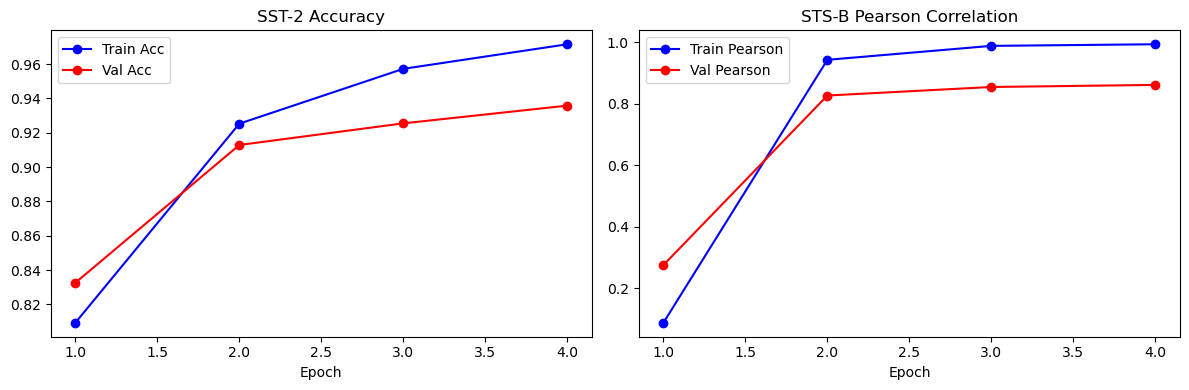

In [ ]:
epochs = range(1, NUM_EPOCHS+1)
plt.figure(figsize=(12,4))

# Plot SST-2 Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, train_accs, 'bo-', label='Train Acc')
plt.plot(epochs, val_accs,   'ro-', label='Val Acc')
plt.title("SST-2 Accuracy")
plt.xlabel("Epoch")
plt.legend()

# Plot STS-B Pearson Correlation
plt.subplot(1,2,2)
plt.plot(epochs, train_corrs, 'bo-', label='Train Pearson')
plt.plot(epochs, val_corrs,   'ro-', label='Val Pearson')
plt.title("STS-B Pearson Correlation")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
final_sst2_acc = eval_sst2(val_sst2)
final_stsb_corr = eval_stsb(val_stsb)
print(f"Final SST-2 Validation Accuracy: {final_sst2_acc:.4f}")
print(f"Final STS-B Validation Pearson Correlation: {final_stsb_corr:.4f}")


Final SST-2 Validation Accuracy: 0.9358
Final STS-B Validation Pearson Correlation: 0.8607


In [ ]:
def test_semantic_similarity(sentence1, sentence2):
    """
    Compute a semantic similarity score between two sentences using the model.
    A higher score indicates a greater similarity.
    """
    model.eval()  # Set model to evaluation mode
    # Tokenize the sentence pair
    enc = tokenizer(
        sentence1,
        sentence2,
        padding=True,
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)
    with torch.no_grad():
        _, score = model(input_ids, attention_mask)
    return score.item()  # Return the computed similarity score as a float

# Example usage for semantic similarity
s1 = "I want to fall asleep"
s2 = "I would like to go to bed"
similarity_score = test_semantic_similarity(s1, s2)
print(f"Semantic similarity score: {similarity_score:.3f}")

Semantic similarity score: 4.219


In [ ]:
def test_sentiment(sentence):
    """
    Predict the sentiment of a given sentence using the model.
    Returns "positive" if predicted class is 1, and "negative" otherwise.
    """
    model.eval()  # Switch to evaluation mode
    enc = tokenizer(
        sentence,
        padding=True,
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)
    with torch.no_grad():
        logits, _ = model(input_ids, attention_mask)
        pred = logits.argmax(dim=1).item()  # Get the predicted class index
    sentiment = "positive" if pred == 1 else "negative"  # Map prediction to sentiment label
    return sentiment

# Example usage for sentiment classification
sentence = "This movie was absolutely wonderful!"
sentiment = test_sentiment(sentence)
print(f"Sentiment: {sentiment}")

Sentiment: positive


In [ ]:
# Save the model's state_dict
torch.save(model.state_dict(), "multi_task_model.pth")

## Summary

- Implemented a multi-task sentence transformer using `all-mpnet-base-v2`, with mean pooling and two linear heads.
- Employed progressive layer unfreezing and PCGrad for stable, balanced multi-task optimization.
- Achieved high accuracy and correlation on GLUE SST-2 and STS-B tasks, demonstrating the effectiveness of shared representations and careful transfer learning strategies.